# Neural Nets
##### Sean Wade

In [3]:
from __future__ import division, print_function
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
import tensorflow as tf
from tabulate import tabulate
import time

from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline

from IPython.core.display import HTML
import urllib2
HTML(urllib2.urlopen('http://seanwade.com/jupyter.ccs').read())

## The Data

The goal of this dataset is predicting if breast cancer is malignant or benign.

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 3 is Mean Radius, field
        13 is Radius SE, field 23 is Worst Radius.

        - class:
                - WDBC-Malignant
                - WDBC-Benign

In [4]:
breast_cancer = load_breast_cancer()

In [5]:
data, labels = breast_cancer['data'], breast_cancer['target']
x_train, x_test, y_train, y_test = train_test_split(data, labels, train_size=.7)

In [6]:
print(x_train.shape, y_train.shape)

(398, 30) (398,)


## Vanilla Model

### Data Processing

In [7]:
def processLabels(labels):
    return np.place(labels, labels==0, -1)

In [8]:
def dataIter(batch_size, x_train, y_train):
    ''' Simple minibatch generator. '''
    num_data = x_train.shape[0]
    start = 0
    while start < num_data:
        end = start+batch_size
        if end > num_data:
            end = num_data
        rows = range(start, end)
        x_batch, y_batch = x_train[rows], y_train[rows]
        yield x_batch, y_batch
        start += batch_size

In [9]:
y_train = np.expand_dims(y_train, axis=1)
y_test = np.expand_dims(y_test, axis=1)
processLabels(y_train)
processLabels(y_test)

In [20]:
# Set parameters
LEARNING_RATE = 0.0001
EPOCHS = 5000
BATCH_SIZE = 28
NUM_DATA = x_train.shape[0]

In [21]:
# Set Placeholders
x = tf.placeholder(tf.float32, [None, 30]) 
y = tf.placeholder(tf.float32, [None, 1])

# Init Weights
W1 = tf.Variable(tf.random_normal([30, 100], stddev=0.35))
b1 = tf.Variable(tf.zeros([100]))
W2 = tf.Variable(tf.random_normal([100, 50], stddev=0.35))
b2 = tf.Variable(tf.zeros([50]))
W3 = tf.Variable(tf.random_normal([50, 1], stddev=0.35))
b3 = tf.Variable(tf.zeros([1]))

# Build Computational Graph
a1 = tf.nn.relu(tf.matmul(x, W1) + b1)
a2 = tf.nn.relu(tf.matmul(a1, W2) + b2)
y_hat = tf.matmul(a2, W3) + b3
   
cost_function = tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(y, y_hat))))

predicted_class = tf.greater(y_hat, 0.)
correct = tf.equal(predicted_class, tf.equal(y, 1.0))
accuracy = tf.reduce_mean( tf.cast(correct, 'float') )

optimizer = tf.train.AdamOptimizer(LEARNING_RATE).minimize(cost_function)
    
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)

    for iteration in range(EPOCHS):
        total_batch = int(NUM_DATA / BATCH_SIZE)
        x_train, y_train = shuffle(x_train, y_train)
        batchGenerator = dataIter(BATCH_SIZE, x_train, y_train)
        
        for i in range(total_batch):
            batch_xs, batch_ys = batchGenerator.next()
            batch_xs, batch_ys = batch_xs, batch_ys
            loss, acc, _ = sess.run([cost_function, accuracy, optimizer], feed_dict={x: batch_xs, y: batch_ys})
            
        # Display logs per iteration step
        if iteration % 100 == 0:
            print('[%04d]' % (iteration + 1), "cost:", "{:.6f}".format(loss), "acc:", "{:.6f}".format(acc))
            
print('--- COMPLETE ---')

[0001] cost: 869.194031 acc: 0.428571
[0101] cost: 8.487897 acc: 0.571429
[0201] cost: 6.584018 acc: 0.464286
[0301] cost: 3.984646 acc: 0.321429
[0401] cost: 2.007297 acc: 0.535714
[0501] cost: 1.481604 acc: 0.714286
[0601] cost: 2.252599 acc: 0.642857
[0701] cost: 1.985056 acc: 0.642857
[0801] cost: 2.413665 acc: 0.571429
[0901] cost: 1.711189 acc: 0.714286
[1001] cost: 1.270986 acc: 0.750000
[1101] cost: 1.057030 acc: 0.785714
[1201] cost: 1.095464 acc: 0.714286
[1301] cost: 1.476326 acc: 0.785714
[1401] cost: 1.101682 acc: 0.714286
[1501] cost: 3.138006 acc: 0.607143
[1601] cost: 1.401028 acc: 0.607143
[1701] cost: 2.150162 acc: 0.642857
[1801] cost: 1.217564 acc: 0.714286
[1901] cost: 1.279907 acc: 0.785714
[2001] cost: 3.316322 acc: 0.357143
[2101] cost: 1.733331 acc: 0.607143
[2201] cost: 1.349465 acc: 0.857143
[2301] cost: 0.534258 acc: 0.964286
[2401] cost: 1.884323 acc: 0.750000
[2501] cost: 1.648497 acc: 0.714286
[2601] cost: 0.898885 acc: 0.678571
[2701] cost: 0.904319 acc:

## Adjusting Hyperparameters

In [9]:
def gridSearch(cv_params):
    gs = GridSearchCV(MLPClassifier(), cv_params) 
    return gs.fit(data, labels)

In [10]:
def gridResults(gs):
    sort_idx = np.argsort(gs.cv_results_['mean_test_score'])[::-1]
    params = np.array(gs.cv_results_["params"])[sort_idx]
    train_time = gs.cv_results_["mean_fit_time"][sort_idx]
    acc = gs.cv_results_["mean_test_score"][sort_idx]
    table = []
    for i in range(len(params)):
         table.append(['%.3f' % acc[i], '%.4f' % train_time[i], params[i]])
    print(tabulate(table, headers=['Accuracy', 'Time', 'Parameters']))

In [20]:
cv_params = {'hidden_layer_sizes': [10,30,50,100,200,500,1000]}
gs = gridSearch(cv_params)
gridResults(gs)

  Accuracy    Time  Parameters
----------  ------  ----------------------------
     0.877  0.0513  {'hidden_layer_sizes': 500}
     0.84   0.1386  {'hidden_layer_sizes': 1000}
     0.685  0.0057  {'hidden_layer_sizes': 30}
     0.589  0.0544  {'hidden_layer_sizes': 50}
     0.582  0.0064  {'hidden_layer_sizes': 10}
     0.457  0.0122  {'hidden_layer_sizes': 200}
     0.346  0.0093  {'hidden_layer_sizes': 100}


In [24]:
cv_params = {'hidden_layer_sizes': [(500,)*i for i in range(1,6)]}
gs = gridSearch(cv_params)
gridResults(gs)

  Accuracy    Time  Parameters
----------  ------  -------------------------------------------------
     0.914  0.1628  {'hidden_layer_sizes': (500,)}
     0.849  4.0482  {'hidden_layer_sizes': (500, 500, 500, 500, 500)}
     0.801  1.9448  {'hidden_layer_sizes': (500, 500, 500, 500)}
     0.691  1.2829  {'hidden_layer_sizes': (500, 500, 500)}
     0.408  0.2679  {'hidden_layer_sizes': (500, 500)}


In [31]:
cv_params = {
    'batch_size':[28, 32, 64, 124],
    'hidden_layer_sizes':[(500,)]
}
gs = gridSearch(cv_params)
gridResults(gs)

  Accuracy    Time  Parameters
----------  ------  -------------------------------------------------
     0.914  0.135   {'batch_size': 64, 'hidden_layer_sizes': (500,)}
     0.914  0.1443  {'batch_size': 28, 'hidden_layer_sizes': (500,)}
     0.91   0.1383  {'batch_size': 32, 'hidden_layer_sizes': (500,)}
     0.893  0.0835  {'batch_size': 124, 'hidden_layer_sizes': (500,)}


In [36]:
cv_params = {
 'alpha': [10**i for i in range(-5,1)],
 'hidden_layer_sizes': [(500,), (500,)*4],
 'batch_size': [64, 28]
}
gs = gridSearch(cv_params)
gridResults(gs)

  Accuracy     Time  Parameters
----------  -------  -------------------------------------------------------------------------------
     0.926   5.2032  {'alpha': 1e-05, 'batch_size': 64, 'hidden_layer_sizes': (500, 500, 500, 500)}
     0.919  73.8706  {'alpha': 1, 'batch_size': 28, 'hidden_layer_sizes': (500, 500, 500, 500)}
     0.919   0.1546  {'alpha': 1e-05, 'batch_size': 64, 'hidden_layer_sizes': (500,)}
     0.917   5.1374  {'alpha': 1e-05, 'batch_size': 28, 'hidden_layer_sizes': (500, 500, 500, 500)}
     0.914   0.1498  {'alpha': 0.0001, 'batch_size': 64, 'hidden_layer_sizes': (500,)}
     0.91    0.1103  {'alpha': 0.0001, 'batch_size': 28, 'hidden_layer_sizes': (500,)}
     0.91    4.4898  {'alpha': 0.1, 'batch_size': 64, 'hidden_layer_sizes': (500, 500, 500, 500)}
     0.91    0.1399  {'alpha': 0.01, 'batch_size': 28, 'hidden_layer_sizes': (500,)}
     0.909   5.3362  {'alpha': 0.01, 'batch_size': 28, 'hidden_layer_sizes': (500, 500, 500, 500)}
     0.907   2.8531  {'alpha'

### Analysis

Based on the above cross validation the optimal width of the hidden layers seems to be around 500.  The depth seems to favor larger number only slightly with significant time costs.  As far as batch size, 64 is a good number with 28 also beign a good choice.  A low alpha around .0001 also seems to be the best.

## Comparison

In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb

In [40]:
def testModel(model, data, labels, num_tests=3):
    ''' Tests a model for comparison by averaging results.
    Args:
      model: sklearn model
      data : dataset
      lables : lables
      num_tests : number of times to average
    
    Returns:
      avg_score : the average model score
      avg_time : the average training time
    '''
    
    scores = []
    train_times = []
    for _ in range(num_tests):
        x_train, x_test, y_train, y_test = train_test_split(data, labels, train_size=.7)
        start = time.time()
        model.fit(x_train, y_train)
        stop = time.time()
        train_times.append(stop - start)
        scores.append(model.score(x_test, y_test))
        
    return np.mean(scores), np.mean(train_times)


model_list = [
    LogisticRegression(),
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    GradientBoostingClassifier(),
    xgb.XGBClassifier(),
    MLPClassifier(hidden_layer_sizes=(500,))
]

model_names = [
    'Logistic Regression',
    'KNN',
    'Descision Tree',
    'Random Forrests',
    'Gradient Boosting',
    'XGBoost',
    'MLP'
]

score_list = []
time_list = []

for model in model_list:
    score, train_time = testModel(model, data, labels)
    score_list.append(score)
    time_list.append(train_time)
    
print(tabulate([[x,y,z] for x,y,z in zip(model_names, score_list, time_list)],
               headers=['Model', 'Accuracy', 'Time']))

Model                  Accuracy         Time
-------------------  ----------  -----------
Logistic Regression    0.94347   0.0040373
KNN                    0.927875  0.000401258
Descision Tree         0.937622  0.00481955
Random Forrests        0.935673  0.0320044
Gradient Boosting      0.957115  0.126557
XGBoost                0.966862  0.112209
MLP                    0.912281  0.178757


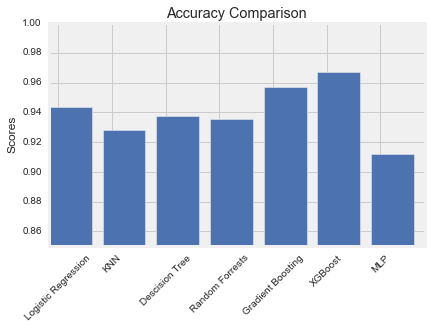

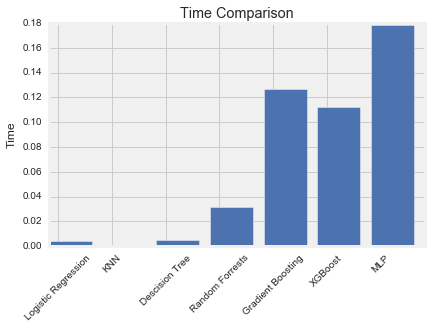

In [41]:
# Plot Results
f, ax = plt.subplots()
ind = np.arange(len(score_list))
bar_1 = ax.bar(ind, score_list)
ax.set_ylabel('Scores')
ax.set_title('Accuracy Comparison')
ax.set_xticks(ind + .35 / 2)
ax.set_xticklabels(model_names, rotation=45)
plt.ylim(.85,1)
plt.show()

f, ax = plt.subplots()
ind = np.arange(len(time_list))
bar_1 = ax.bar(ind, time_list)
ax.set_ylabel('Time')
ax.set_title('Time Comparison')
ax.set_xticks(ind + .35 / 2)
ax.set_xticklabels(model_names, rotation=45)
plt.show()

### Results

Adding on the MLP we can see that we arn't doing that great...  On average it is the worst of the classifiers and takes by far the longest to train.  This is partially due to the datase. Since it is so small and not very complex, we do not get to see the MLP shine.

## Extra Credit

In [54]:
scores = []
for _ in range(10):
    x_train, x_test, y_train, y_test = train_test_split(data, labels, train_size=.7)
    #x_train = preprocessing.scale(x_train)
    #x_test = preprocessing.scale(x_test)
    
    params = {'hidden_layer_sizes': (500,500,500,500), 
          'alpha': .001,
          'batch_size': 64,
          'max_iter': 200 }
    
    model = MLPClassifier(**params)
    model.fit(x_train, y_train)
    scores.append(model.score(x_test, y_test))
    
print("Accuracy: %.3f" % np.mean(scores))

Accuracy: 0.907
